# **GIS-Projekt** WS2025/26 @ HS Mainz
Prof. Dr.-Ing. Yu Feng

---

## Übung: Fahrzeugerkennung mit vYOLOv8

**Ziele der Übung**
- Ein vortrainiertes Modell auf Luft-/Satellitenbilder anwenden und **Fahrzeuge detektieren**.
- Auf [Hugging Face Models](https://huggingface.co/models) nach **„VisDrone“** oder **„UAV“** suchen, **weitere Modelle** herunterladen und vergleichen. e.g., https://huggingface.co/erbayat; https://huggingface.co/Mahadih534/YoloV8-VisDrone

- **WMS**-Kartenausschnitte (z. B. Mainz Hbf) in **verschiedenen Maßstäben** abrufen, die Detektion ausführen und bewerten, **welcher Maßstab für ein GIS‑Projekt** am besten geeignet ist.

**Arbeitsstruktur (Empfehlung)**
```
detect_cars.ipynb
model/
  visDrone.pt
test/
  Elly-Beinhorn-Straße_16.jpg
```


In [45]:
# ⬇️ Abhängigkeiten installieren (Colab)
!pip -q install ultralytics requests pyproj

In [46]:
import os, json, csv, cv2, requests, glob
from ultralytics import YOLO
from matplotlib import pyplot as plt
from pyproj import Transformer
from urllib.parse import urlencode
import pandas as pd

# Verzeichnisse in demselben Folder anlegen
os.makedirs("model", exist_ok=True)
os.makedirs("test", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

print("Bitte laden Sie Ihre Modelle in ./model und Testbilder in ./test")

Bitte laden Sie Ihre Modelle in ./model und Testbilder in ./test


### Beispiel 1: Offizielles YOLOv8-Modell testen


image 1/1 /content/test/Elly-Beinhorn-Straße_16.jpg: 1280x1280 (no detections), 5105.8ms
Speed: 20.0ms preprocess, 5105.8ms inference, 5.4ms postprocess per image at shape (1, 3, 1280, 1280)


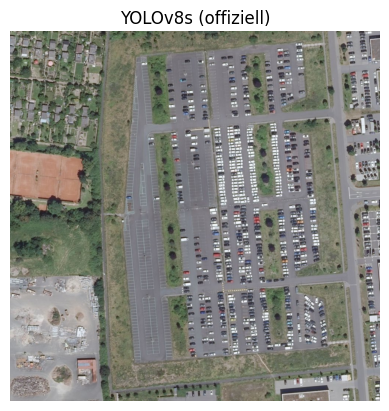

In [47]:
# YOLOv8s herunterladen (falls nicht vorhanden)
if not os.path.exists("model/yolov8s.pt"):
    !wget -q -O model/yolov8s.pt https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8s.pt

model_path = "model/yolov8s.pt"
test_image = "test/Elly-Beinhorn-Straße_16.jpg"

model = YOLO(model_path)
results = model(test_image, classes=[2,3,5,7], conf=0.20, imgsz=1280)

for r in results:
    im = r.plot(line_width=2, labels=False, conf=False)
    cv2.imwrite("outputs/annotated_yolov8s.png", im)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("YOLOv8s (offiziell)")
    plt.show()


## Beispiel 2: VisDrone-Modell testen


image 1/1 /content/test/wms_60m.jpg: 1280x1280 199 cars, 24 trucks, 24504.0ms
Speed: 95.3ms preprocess, 24504.0ms inference, 42.5ms postprocess per image at shape (1, 3, 1280, 1280)


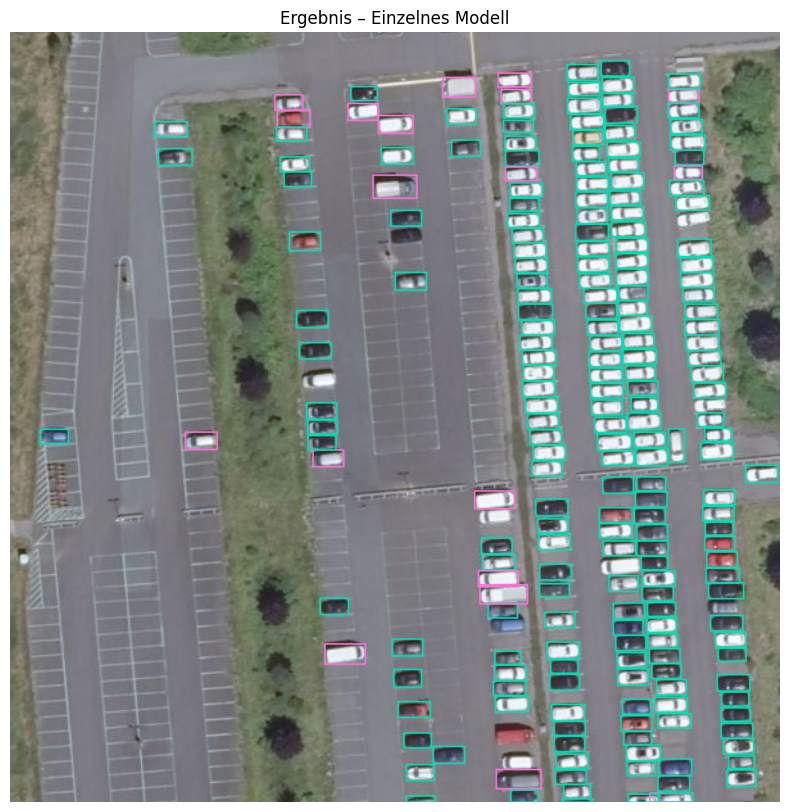

Gefundene Fahrzeuge: 223 – Bild: /content/outputs/annotated_single.png


In [48]:
model_path = "/content/model/yolo11x-visdrone.pt"
test_image = "/content/test/wms_60m.jpg"

model = YOLO(model_path)
results = model(test_image, classes=[2,3,5,7], conf=0.20, imgsz=1280)

detections = []
for r in results:
    im = r.plot(line_width=2, labels=False, conf=False)
    out_img = "/content/outputs/annotated_single.png"
    cv2.imwrite(out_img, im)
    for b in r.boxes:
        x1,y1,x2,y2 = [int(v) for v in b.xyxy[0].tolist()]
        detections.append({
            "x1": x1, "y1": y1, "x2": x2, "y2": y2,
            "confidence": float(b.conf[0]),
            "class": r.names[int(b.cls[0])]
        })

with open("/content/outputs/detections_single.json", "w", encoding="utf-8") as f:
    json.dump(detections, f, ensure_ascii=False, indent=2)
pd.DataFrame(detections).to_csv("/content/outputs/detections_single.csv", index=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis("off"); plt.title("Ergebnis – Einzelnes Modell")
plt.show()

print(f"Gefundene Fahrzeuge: {len(detections)} – Bild: {out_img}")

## 2) Vergleich mehrerer Modelle (HuggingFace‑Recherche)

In [49]:
model_files = sorted(glob.glob("/content/model/*.pt")) + sorted(glob.glob("/content/weights/*.pt"))
print("Modelle:", model_files)

summary = []
for mpath in model_files:
    try:
        print(f"🔎 Modell: {os.path.basename(mpath)}")
        mdl = YOLO(mpath)
        res = mdl(test_image, classes=[2,3,5,7], conf=0.20, imgsz=1280)
        dets = []
        for r in res:
            im = r.plot()
            base = os.path.splitext(os.path.basename(mpath))[0]
            out_img = f"/content/outputs/{base}_annotated.png"
            cv2.imwrite(out_img, im)
            for b in r.boxes:
                x1,y1,x2,y2 = [int(v) for v in b.xyxy[0].tolist()]
                dets.append({
                    "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                    "confidence": float(b.conf[0]),
                    "class": r.names[int(b.cls[0])]
                })
        with open(f"/content/outputs/{base}_detections.json", "w", encoding="utf-8") as f:
            json.dump(dets, f, ensure_ascii=False, indent=2)
        pd.DataFrame(dets).to_csv(f"/content/outputs/{base}_detections.csv", index=False)
        summary.append({"model": os.path.basename(mpath), "detections": len(dets)})
    except Exception as ex:
        print("Fehler bei", mpath, "->", ex)

pd.DataFrame(summary).sort_values("detections", ascending=False).reset_index(drop=True)

Modelle: ['/content/model/visDrone.pt', '/content/model/yolo11l-visdrone.pt', '/content/model/yolo11x-visdrone.pt', '/content/model/yolov8s.pt']
🔎 Modell: visDrone.pt

image 1/1 /content/test/wms_60m.jpg: 1280x1280 196 cars, 10 trucks, 3300.0ms
Speed: 30.9ms preprocess, 3300.0ms inference, 68.4ms postprocess per image at shape (1, 3, 1280, 1280)
🔎 Modell: yolo11l-visdrone.pt

image 1/1 /content/test/wms_60m.jpg: 1280x1280 203 cars, 7406.6ms
Speed: 16.2ms preprocess, 7406.6ms inference, 39.6ms postprocess per image at shape (1, 3, 1280, 1280)
🔎 Modell: yolo11x-visdrone.pt

image 1/1 /content/test/wms_60m.jpg: 1280x1280 199 cars, 24 trucks, 17501.6ms
Speed: 15.3ms preprocess, 17501.6ms inference, 43.7ms postprocess per image at shape (1, 3, 1280, 1280)
🔎 Modell: yolov8s.pt

image 1/1 /content/test/wms_60m.jpg: 1280x1280 (no detections), 2332.7ms
Speed: 15.7ms preprocess, 2332.7ms inference, 3.6ms postprocess per image at shape (1, 3, 1280, 1280)


,model,detections
0,yolo11x-visdrone.pt,223
1,visDrone.pt,206
2,yolo11l-visdrone.pt,203
3,yolov8s.pt,0


## 3) WMS‑Ausschnitte (Mainz Hbf, 2024) in verschiedenen Maßstäben

In [50]:
WMS_BASE = "https://geo4.service24.rlp.de/wms/rp_hkdop20.fcgi"
WMS_LAYER = "rp_dop20_rgb_2024"

lat, lon = 49.978161302273485, 8.27698779850867
transformer = Transformer.from_crs("EPSG:4326", "EPSG:25832", always_xy=True)
E, N = transformer.transform(lon, lat)

def get_wms_image(buffer_m=1000, width=1600, height=1600, outfile="wms.jpg"):
    bbox = (E-buffer_m, N-buffer_m, E+buffer_m, N+buffer_m)
    params = {
        "SERVICE": "WMS",
        "VERSION": "1.1.1",
        "REQUEST": "GetMap",
        "LAYERS": WMS_LAYER,
        "STYLES": "default",
        "SRS": "EPSG:25832",
        "FORMAT": "image/jpeg",
        "WIDTH": str(width),
        "HEIGHT": str(height),
        "BBOX": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}",
        "language": "ger",
    }
    url = f"{WMS_BASE}?{urlencode(params)}"
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    path = f"/content/test/{outfile}"
    with open(path, "wb") as f:
        f.write(r.content)
    return path

scales = [("40m", 40), ("50m", 50), ("60m", 60), ("75m", 75), ("100m", 150), ("125m", 125)]
downloaded = [get_wms_image(buffer_m=buf, outfile=f"wms_{label}.jpg") for label, buf in scales]
downloaded

['/content/test/wms_40m.jpg',
 '/content/test/wms_50m.jpg',
 '/content/test/wms_60m.jpg',
 '/content/test/wms_75m.jpg',
 '/content/test/wms_100m.jpg',
 '/content/test/wms_125m.jpg']

In [44]:
model_path = "/content/model/yolo11x-visdrone.pt"
model = YOLO(model_path)

# Detektion auf allen WMS‑Ausschnitten mit dem aktuellen Modell
records = []
for p in downloaded:
    res = model(p, classes=[2,3,5,7], conf=0.20, imgsz=1536)
    for r in res:
        im = r.plot(line_width=2, labels=False, conf=False)
        base = os.path.splitext(os.path.basename(p))[0]
        out_img = f"/content/outputs/{base}_annotated.png"
        cv2.imwrite(out_img, im)
        plt.figure(figsize=(8,8))
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.title(f"WMS Detektion – {base}")
        plt.axis("off"); plt.show()
        records.append({"wms_image": base, "detections": int(len(r.boxes))})

import pandas as pd
df_wms = pd.DataFrame(records).sort_values("detections", ascending=False).reset_index(drop=True)
df_wms

Output hidden; open in https://colab.research.google.com to view.

### 4) Leitfragen
- Bei welchem **Puffer/Maßstab** wurden die meisten Fahrzeuge zuverlässig erkannt?
- Gibt es **False Positives** oder **Duplikate**?
- Welche **Parameter** (`conf`, `imgsz`) helfen bei kleinen Objekten?
- Welche Modelle liefern für Ihre **GIS‑Anwendung** die besten Ergebnisse?

## Abschlussaufgabe (OSM + WMS + Fahrzeugdetektion)

**Deine Aufgabe**

1. **OSM-Parkflächen finden**  
   Recherchiere mit der Overpass-API Parkflächen (`amenity=parking`) im Untersuchungsgebiet (z. B. Mainz und Umgebung).  

2. **Drei Parkplätze auswählen**  
   Wähle **beliebige 3 Parkflächen** aus (z. B. mit großer, mittlerer und kleiner Fläche oder unterschiedliche Lage).  

3. **WMS-Bildkacheln laden (RLP DOP20 2024)**  
   Nutze den RLP WMS-Layer `rp_dop20_rgb_2024`, lade für jede Parkfläche **mehrere Maßstäbe** (z. B. 300 m / 800 m / 1500 m Puffer) als Bild.  

4. **Fahrzeugerkennung**  
   Führe mit einem **YOLO-Modell** oder einem **VisDrone/UAV-feinjustierten Modell** die Detektion aus (`car/motorcycle/bus/truck`).  

5. **Vergleich & Bewertung**  
   Vergleiche je Parkplatz und je Maßstab die Anzahl/Qualität der Detektionen.  
   > Welcher **Maßstab** liefert für Deine GIS-Fragestellung die **besten Ergebnisse** (Sichtbarkeit, Fehl-/Mehrfacherkennungen, Reproduzierbarkeit)?

**Hinweise**
- OSM-Abruf: Overpass-API (GeoJSON)  
- WMS-Layer: `rp_dop20_rgb_2024` (Version 1.1.1, SRS `EPSG:25832`)  
- Parameter: `conf` (z. B. 0.20), `imgsz` (z. B. 1280–1536) gern variieren  
- Dokumentiere kurz Deine Wahl der drei Parkflächen und Deine Begründung des Maßstabs

